In [2]:
import os
import dmd
os.environ["OMP_NUM_THREADS"]='8'
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.interpolate import griddata
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

In [3]:
# N=10000
# K=2
# seed=1
# c=1
# t1=100
# dt=1E-2
# atol=1E-10
# fs=np.zeros(N+2)
# ns=[0,1,-1]
# omega=np.zeros(N)

# filebase='data/dmd13'
# loadstr=''
# os.system('mkdir -p %s'%(filebase))

# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=dt
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "%s ./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 0 -D 1 -nvR %s/%i"'%(loadstr,N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

# K=2
# c=1.75
# filebase='data/dmd14'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=dt
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "%s ./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 0 -D 1 -nvR %s/%i"'%(loadstr,N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

# K=N
# c=1.75
# filebase='data/dmd15'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=dt
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "%s ./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 0 -D 1 -nvR %s/%i"'%(loadstr,N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

In [5]:
# os.system('sbatch jobdmd3.sh')

### Input trajectories

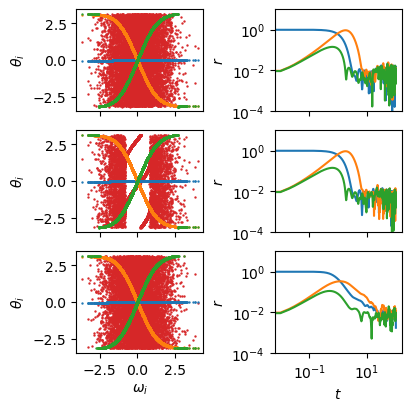

In [6]:
# filebases=['data/dmd1/','data/dmd2/','data/dmd3/']
# filebases=['data/dmd4/','data/dmd5/','data/dmd6/']
# filebases=['data/dmd7/','data/dmd8/','data/dmd9/']
filebases=['data/dmd13/','data/dmd14/','data/dmd15/']
fig,axs=plt.subplots(3,2,figsize=(4,4) ,constrained_layout=True)

numtraj=3

for m in range(len(filebases)):
    # n0s=np.concatenate([[0],np.cumsum(np.load('%s/n0s.npy'%(filebases[m]))-1)])

    for n in range(numtraj):
        filebase='%s/%i'%(filebases[m],n)
        file=open(filebase+'.out')
        lines=file.readlines()
        N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
        N=int(N)
        K=int(K)
        file.close()

    
        omega=np.fromfile(filebase+'frequencies.dat',dtype=np.float64)
        N=len(omega)
        thetas=np.fromfile(filebase+'thetas.dat',dtype=np.float64).reshape((-1,N))
        thetas=thetas-np.mean(omega)*dt*np.arange(thetas.shape[0])[:,np.newaxis]
        orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
    
        plt.subplot(3,2,2+2*m)
        plt.plot(np.arange(len(orders))*dt,orders,c=colors[n],zorder=-5)
        plt.gca().set_rasterization_zorder(0)
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('$r$')
        plt.ylim(1E-4,1E1)
        if m<2:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('$t$')

        
        plt.subplot(3,2,1+2*m)
        plt.scatter(omega,np.mod(thetas[0]+np.pi,2*np.pi)-np.pi,s=0.5,zorder=-5)
        plt.gca().set_rasterization_zorder(0)
        plt.ylabel(r'$\theta_i$')
        
        if m<2:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('$\omega_i$')
    plt.subplot(3,2,1+2*m)
    plt.scatter(omega,np.mod(thetas[-1]+np.pi,2*np.pi)-np.pi,s=0.5,zorder=-6)        
    

# plt.savefig('oscillatordmd1.pdf',dpi=200)
plt.show()

### Mode amplitudes decay exponentially, and order parameter DMD reconstruction is good 

data/dmd13/ 0
data/dmd13/ 1
data/dmd13/ 2
data/dmd14/ 0
data/dmd14/ 1
data/dmd14/ 2
data/dmd15/ 0
data/dmd15/ 1
data/dmd15/ 2


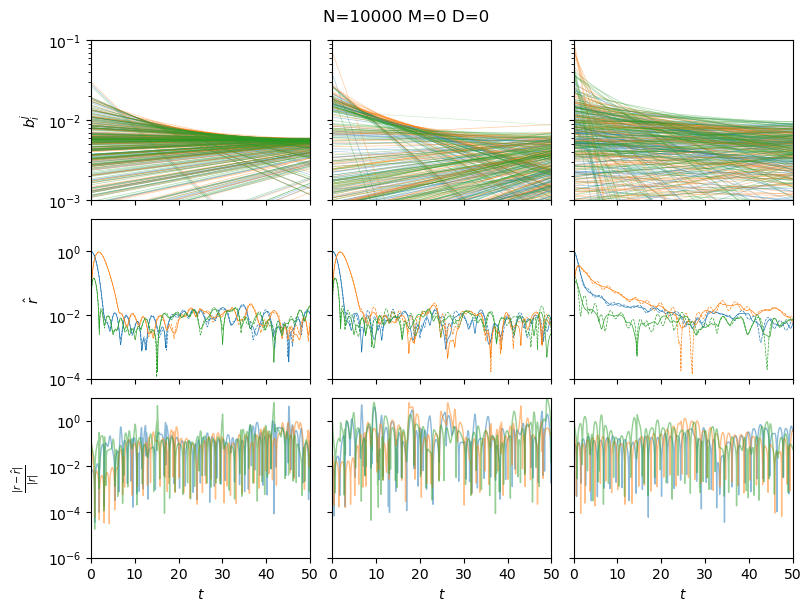

In [8]:
# filebases=['data/dmd13/','data/dmd14/','data/dmd15/']
filebases=['data/dmd13/','data/dmd14/','data/dmd15/']
resmin=1E-4
resmax=1E-10
rescrit=1E-7


# for D in ['0_r','1_r','2_r','3_r','4_r','5_r']:
for D in ['0_r']:
    X_reconstructs=[]
    for filebase0 in filebases:
        phis=np.load('%s%sphis.npy'%(filebase0,D))
        phitildes=np.load('%s%sphitildes.npy'%(filebase0,D))

        bs=np.load('%s%sbs.npy'%(filebase0,D))
        evals=np.load('%s%sevals.npy'%(filebase0,D))
        res=np.load('%s%sres.npy'%(filebase0,D))
        n0s=np.concatenate([[0],np.cumsum(np.load('%s%sn0s.npy'%(filebase0,D))-1)])
        
        inds=np.where(res<rescrit)[0]
        X_reconstruct=np.zeros((bs.shape[0],phis.shape[0]))
        for n in range(numtraj):
            print(filebase0,n)
            n0=n0s[n]
            X_reconstruct[n0:n0s[n+1]]=np.real((bs[n0,inds]*phitildes[inds].T).dot(evals[inds,np.newaxis]**np.arange(n0s[n+1]-n0s[n])[np.newaxis,:])).T
        X_reconstructs=X_reconstructs+[X_reconstruct]

    fig,axs=plt.subplots(3,3,figsize=(8,6),layout='constrained')
    if D==0:
        fig.suptitle('N=%i M=%i D=%i'%(N,1,0))
    else:
        fig.suptitle('N=%i M=%i D=%i'%(N,int(D[0]),N//2*int(D[0])))

    for m in range(len(filebases)):
        filebase0=filebases[m]
        bs=np.load('%s/%sbs.npy'%(filebase0,D))
        evals=np.load('%s/%sevals.npy'%(filebase0,D))
        res=np.load('%s/%sres.npy'%(filebase0,D))
        n0s=np.concatenate([[0],np.cumsum(np.load('%s/%sn0s.npy'%(filebase0,D))-1)])
        inds=np.where(res<rescrit)[0]
        for n in range(numtraj):
            plt.subplot(3,3,m+1)
            inds2=np.argsort(np.abs(bs[n0s[n],inds]))
            # plt.plot(dt*n0s[n]+np.arange(n0s[n+1]-n0s[n])*dt,np.abs(bs[n0s[n]:n0s[n+1],inds[inds2[-100:]]]),c=colors[n],lw=0.1)
            # plt.plot(np.arange(n0s[n+1]-n0s[n])*dt,np.abs(bs[n0s[n]:n0s[n+1],inds[inds2[-100:]]]),c=colors[n],lw=0.1)
            plt.plot(np.arange(n0s[n+1]-n0s[n])*dt,np.abs(bs[n0s[n]:n0s[n+1],inds[inds2[:]]]),c=colors[n],lw=0.5,alpha=0.2)
            plt.ylim(1E-3,1E-1)
            plt.yscale('log')
            # plt.xscale('log')
            plt.ylim(1E-3,1E-1)
            plt.xlim(0,50)
            plt.gca().set_xticklabels('')
    
            if m==0:
                plt.ylabel('$b_i^j$')
            else:
                plt.gca().set_yticklabels('')
            plt.gca().set_xticklabels('')
                    
            plt.subplot(3,3,m+4)
            X_reconstruct=X_reconstructs[m]
            filebase='%s/%i'%(filebases[m],n)
            orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
            # plt.plot(4*n+np.log((1+np.arange(n0s[n+1]-n0s[n]))*dt)/np.log(10),np.abs(np.mean(X_reconstruct[n0s[n]:n0s[n+1],:N]+1j*X_reconstruct[n0s[n]:n0s[n+1],N:],axis=1)),ls='--',c=colors[n],zorder=-5)
            Ndict=X_reconstruct.shape[1]
            plt.plot(np.arange(n0s[n+1]-n0s[n])*dt,np.abs(np.mean(X_reconstruct[n0s[n]:n0s[n+1],:N]+1j*X_reconstruct[n0s[n]:n0s[n+1],Ndict//2:Ndict//2+N],axis=1)),c=colors[n],ls='--',zorder=-5,lw=0.5)
            plt.plot(np.arange(n0s[n+1]-n0s[n])*dt,orders[:-1],c=colors[n],zorder=-5,lw=0.5)
            plt.gca().set_rasterization_zorder(0)
            # plt.xscale('log')
            plt.yscale('log')
            plt.ylim(1E-4,1E1)
            plt.xlim(0,50)
            if m==0:
                plt.ylabel('$\hat{r}$')
            else:
                plt.gca().set_yticklabels('')
            plt.gca().set_xticklabels('')
                
            plt.subplot(3,3,m+7)
            err=np.abs(np.abs(np.mean(X_reconstruct[n0s[n]:n0s[n+1],:N]+1j*X_reconstruct[n0s[n]:n0s[n+1],Ndict//2:Ndict//2+N],axis=1))-orders[:-1])/orders[:-1]
            plt.plot(np.arange(n0s[n+1]-n0s[n])*dt,err,c=colors[n],zorder=-5,lw=1,alpha=0.5)
            plt.gca().set_rasterization_zorder(0)
            # plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('$t$')
            plt.ylim(1E-6,1E1)
            plt.xlim(0,50)
            if m==0:
                plt.ylabel(r'$\frac{ | r-\hat{r}  |}{ | r  |}$')
            else:
                plt.gca().set_yticklabels('')
            


                
    plt.savefig('oscillatordmd3_%s.pdf'%D)
    plt.show()

### DMD spectrum and pseudospectrum

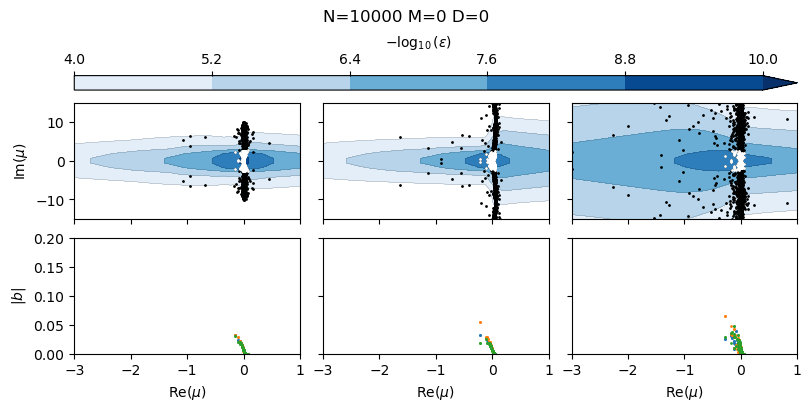

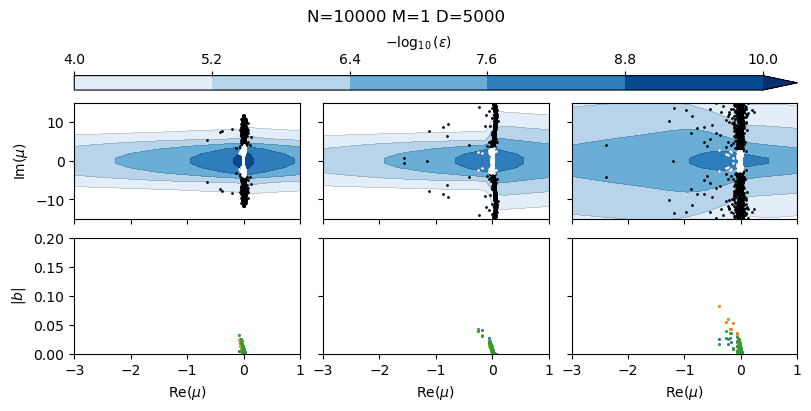

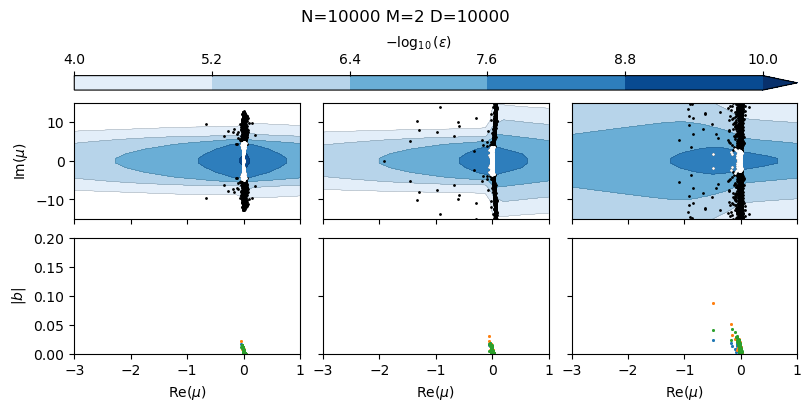

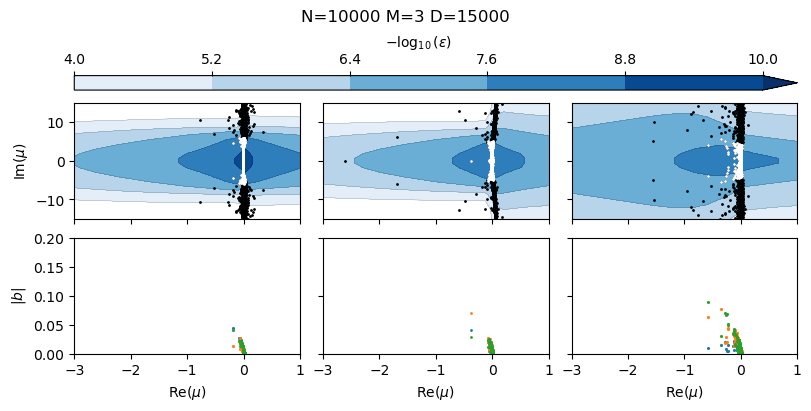

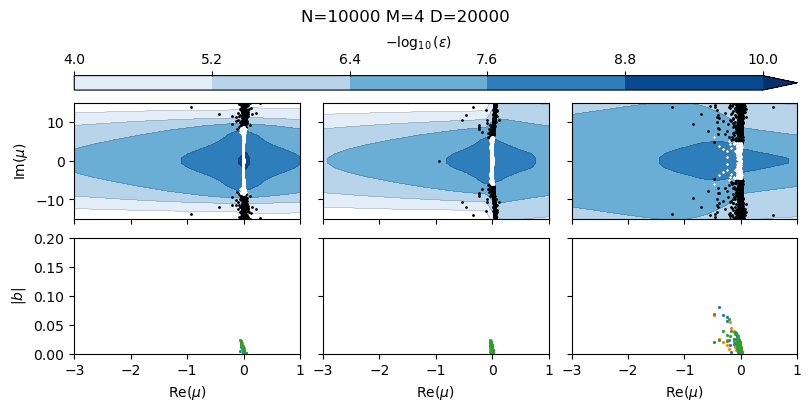

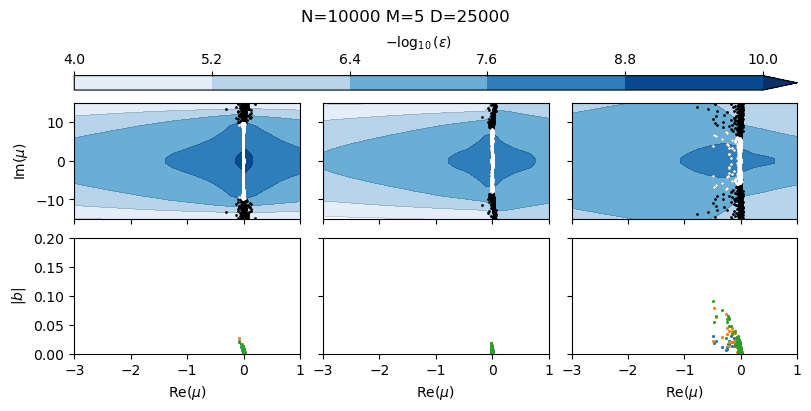

In [9]:
filebases=['data/dmd13/','data/dmd14/','data/dmd15/']
resmin=1E-4
resmax=1E-10
rescrit=1E-7

for D in ['0_r','1_r','2_r','3_r','4_r','5_r']:
    l=0
    fig,axs=plt.subplots(2,3,figsize=(8,4),layout='constrained')
    if D==0:
        fig.suptitle('N=%i M=%i D=%i'%(N,1,0))
    else:
        fig.suptitle('N=%i M=%i D=%i'%(N,int(D[0]),N//2*int(D[0])))
    numtraj=3
    for m in range(len(filebases)):
        filebase0=filebases[m]
        
        bs=np.load(filebase0+str(D)+'bs.npy')
        evals=np.load(filebase0+str(D)+'evals.npy')
        res=np.load(filebase0+str(D)+'res.npy')
        inds=np.where(res<rescrit)[0]
        xs=np.real(np.log(evals)/dt)
        n0s=np.concatenate([[0],np.cumsum(np.load('%s/%sn0s.npy'%(filebase0,D))-1)])
        
        plt.subplot(2,3,4+l)
    
        # plt.scatter(xs,np.abs(bs[0]),c='grey',s=2)
        for n in range(numtraj):
            plt.scatter(xs[inds],np.abs(bs[n0s[n]])[inds],c=colors[n],s=1,zorder=-5)
        plt.gca().set_rasterization_zorder(0)
    
        plt.xlabel(r'$\mathrm{Re}(\mu)$')
        plt.xlim(-3,1)
        plt.ylim(0,0.5)
        if l>0:
            plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
        else:
            plt.ylabel(r'$|b|$')
        plt.ylim(0,0.2)
    
        pseudo1=np.load('%s/%spseudo.npy'%(filebase0,D))
        zs1=np.load('%s/%szs.npy'%(filebase0,D))
        evals1=np.load('%s/%sevals.npy'%(filebase0,D))
        res1=np.load('%s/%sres.npy'%(filebase0,D))
        nr=26
        ni=26
        
        levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5
    
        plt.subplot(2,3,1+l)
        cs1 = plt.gca().tricontourf(np.real(np.log(zs1)/dt),np.imag(np.log(zs1)/dt),np.log(1/np.array(pseudo1))/np.log(10),levels=levels,cmap='Blues',extend='max',zorder=-5)
        cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1,zorder=-5)
    
        plt.gca().set_rasterization_zorder(0)
        plt.xlim(-3,1)
        plt.ylim(-15,15)
        
        xs1=np.real(np.log(evals1)/dt)
        ys1=np.imag(np.log(evals1)/dt)
    
        inds=np.where(res1<rescrit)[0]
        plt.scatter(xs1,ys1,c='black',s=1,zorder=-5)
        plt.scatter(xs1[inds],ys1[inds],c='white',s=1,zorder=-5)
        
        if l>0:
            plt.gca().set_yticklabels([])
        else:
            plt.ylabel('$\mathrm{Im}({\mu})$')
        plt.gca().set_xticklabels('')
    
        l=l+1
    
    fig.colorbar(cs1, ax=axs[:,:], location='top',aspect=50,label=r'$-\log_{10}(\varepsilon)$')
    
    plt.savefig('oscillatordmd2_%s.pdf'%D,dpi=200)
    plt.show()
    

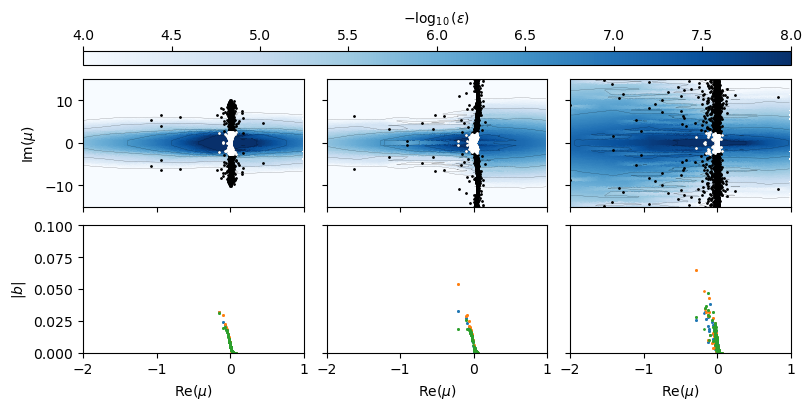

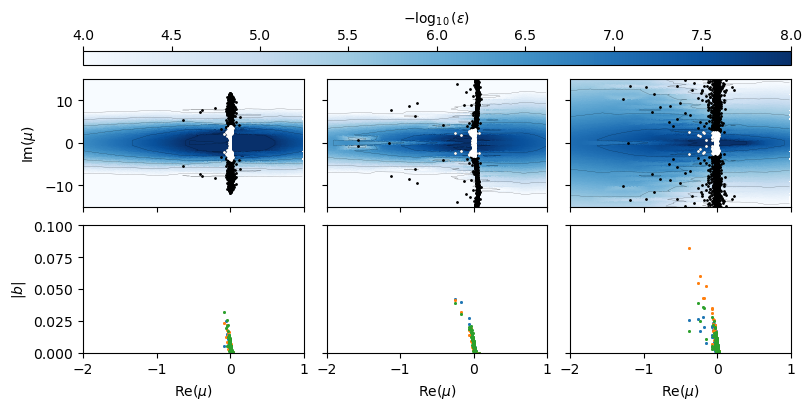

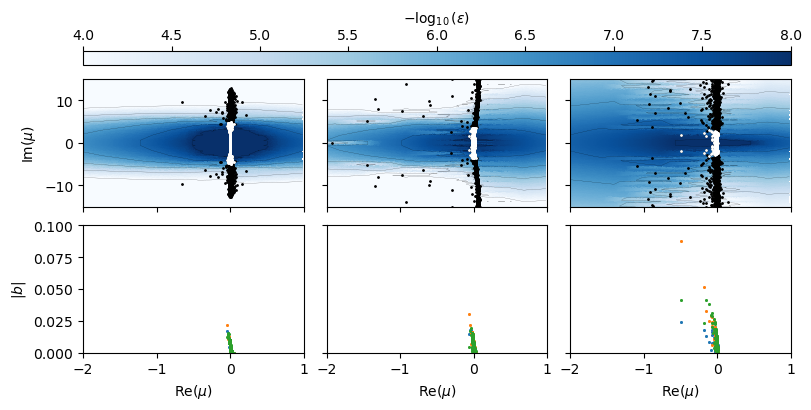

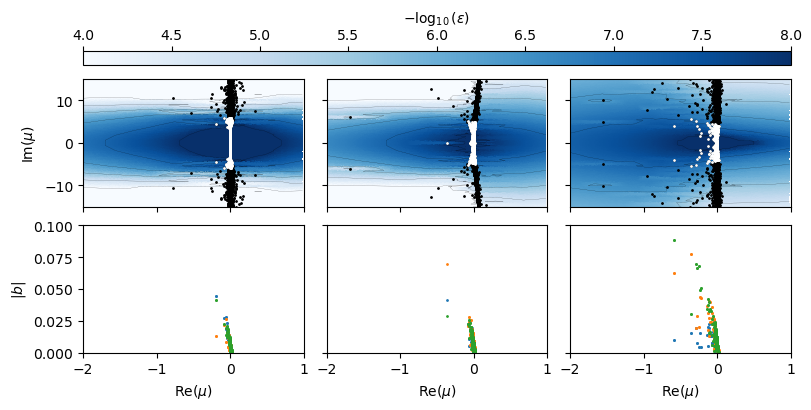

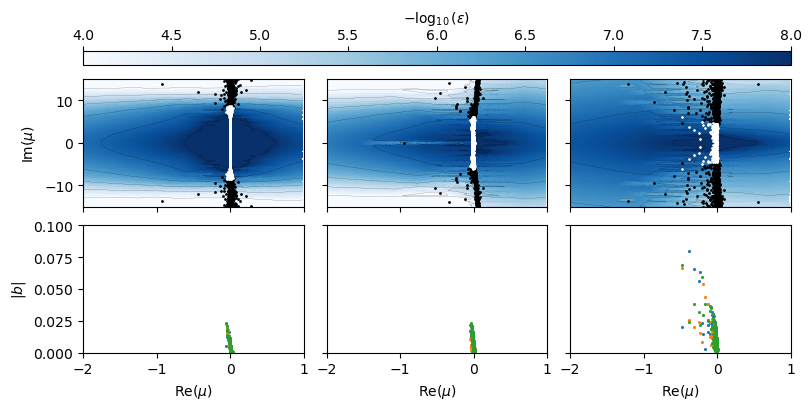

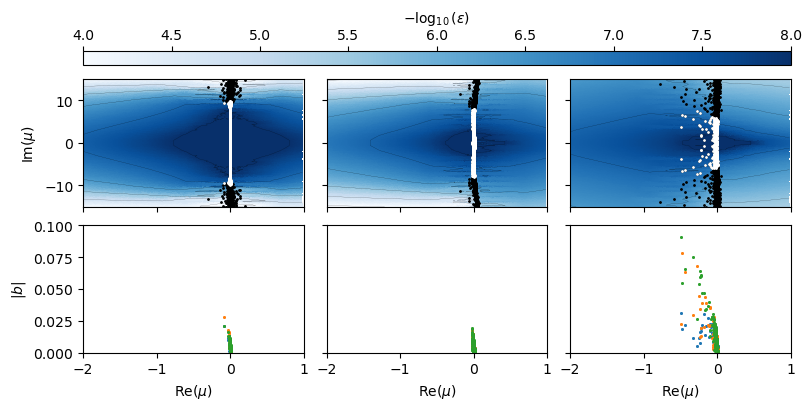

In [3]:
filebases=['data/dmd13/','data/dmd14/','data/dmd15/']
omega=np.fromfile(filebases[0]+'0'+'frequencies.dat',dtype=np.float64)
N=len(omega)

resmin=1E-4
resmax=1E-10
rescrit=1E-7

for D in ['0_r','1_r','2_r','3_r','4_r','5_r']:
    l=0
    fig,axs=plt.subplots(2,3,figsize=(8,4),layout='constrained')
    if D==0:
        fig.suptitle('N=%i M=%i D=%i'%(N,1,0))
    else:
        fig.suptitle('N=%i M=%i D=%i'%(N,int(D[0]),N//2*int(D[0])))
    numtraj=3
    for m in range(len(filebases)):
        try:
            filebase0=filebases[m]

            bs=np.load(filebase0+str(D)+'bs.npy')
            evals=np.load(filebase0+str(D)+'evals.npy')
            res=np.load(filebase0+str(D)+'res.npy')
            inds=np.where(res<rescrit)[0]
            xs=np.real(np.log(evals)/dt)
            n0s=np.concatenate([[0],np.cumsum(np.load('%s/%sn0s.npy'%(filebase0,D))-1)])

            plt.subplot(2,3,4+l)

            # plt.scatter(xs,np.abs(bs[0]),c='grey',s=2)
            for n in range(numtraj):
                plt.scatter(xs[inds],np.abs(bs[n0s[n]])[inds],c=colors[n],s=1,zorder=-5)
            plt.gca().set_rasterization_zorder(0)

            plt.xlabel(r'$\mathrm{Re}(\mu)$')
            plt.xlim(-2,1)
            plt.ylim(0,0.5)
            if l>0:
                plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
            else:
                plt.ylabel(r'$|b|$')
            plt.ylim(0,0.1)

            pseudo1=np.load('%s/%spseudo.npy'%(filebase0,D))
            zs1=np.load('%s/%szs.npy'%(filebase0,D))
            evals1=np.load('%s/%sevals.npy'%(filebase0,D))
            res1=np.load('%s/%sres.npy'%(filebase0,D))
            nr=26
            ni=26

            levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5

            plt.subplot(2,3,1+l)
    #         cs1 = plt.gca().tricontour(np.real(np.log(zs1)/dt),np.imag(np.log(zs1)/dt),np.log(1/np.array(pseudo1))/np.log(10),levels=levels,colors='k',lw=1,extend='max',zorder=-5)
    #         cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1,zorder=-5)
            X=np.concatenate([np.real(np.log(zs1)/dt),np.real(np.log(evals1)/dt)])
            Y=np.concatenate([np.imag(np.log(zs1)/dt),np.imag(np.log(evals1)/dt)])
            C=np.concatenate([np.log(1/np.array(pseudo1))/np.log(10),np.log(1/np.array(res1))/np.log(10)])

            x=-3+4*np.arange(256)/256
            y=-15+30*np.arange(256)/256
            X2,Y2=np.meshgrid(x,y)
            xi=np.array([X2,Y2]).transpose(1,2,0).reshape(-1,2)
            C2=griddata(np.array([X,Y]).T,C,xi)
            cs2=plt.gca().tripcolor(X2.ravel(),Y2.ravel(),C2,cmap='Blues',zorder=-6,vmin=-np.log(resmin)/np.log(10),vmax=-np.log(resmax)/np.log(10))
            inds=np.where(np.isfinite(C2))[0]
            cs1 = plt.gca().tricontour(X2.ravel()[inds],Y2.ravel()[inds],C2[inds],levels=levels,colors='k',linewidths=0.1,extend='max',zorder=-5)

            plt.gca().set_rasterization_zorder(0)
            plt.xlim(-2,1)
            plt.ylim(-15,15)

            xs1=np.real(np.log(evals1)/dt)
            ys1=np.imag(np.log(evals1)/dt)

            inds=np.where(res1<rescrit)[0]
            plt.scatter(xs1,ys1,c='black',s=1,zorder=-5)
            plt.scatter(xs1[inds],ys1[inds],c='white',s=1,zorder=-5)

            if l>0:
                plt.gca().set_yticklabels([])
            else:
                plt.ylabel('$\mathrm{Im}({\mu})$')
            plt.gca().set_xticklabels('')
        except:
            continue
        l=l+1
    
    fig.colorbar(cs2, ax=axs[:,:], location='top',aspect=50,label=r'$-\log_{10}(\varepsilon)$')
    
    plt.savefig('oscillatordmd2_%s.pdf'%D,dpi=200)
    plt.show()
    

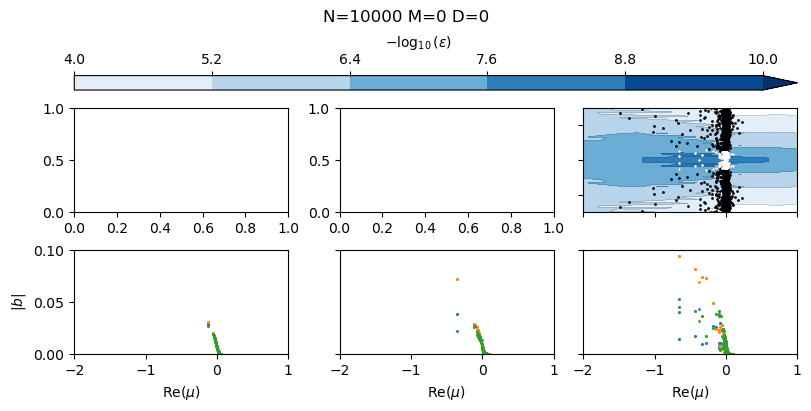

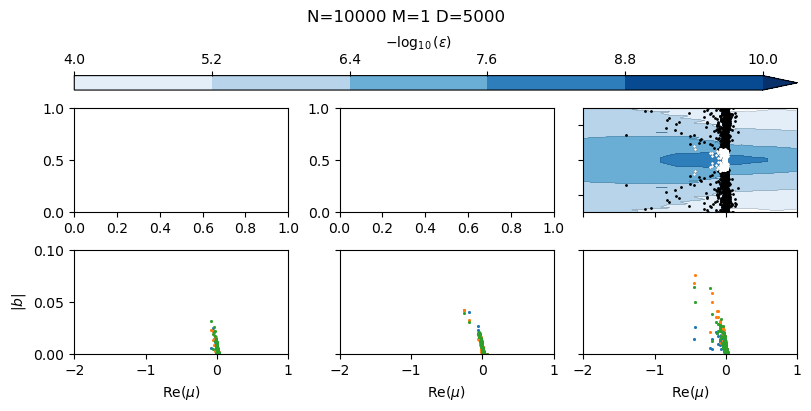

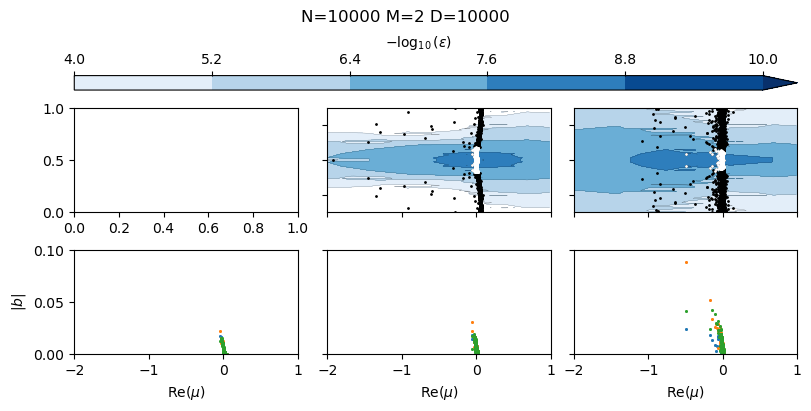

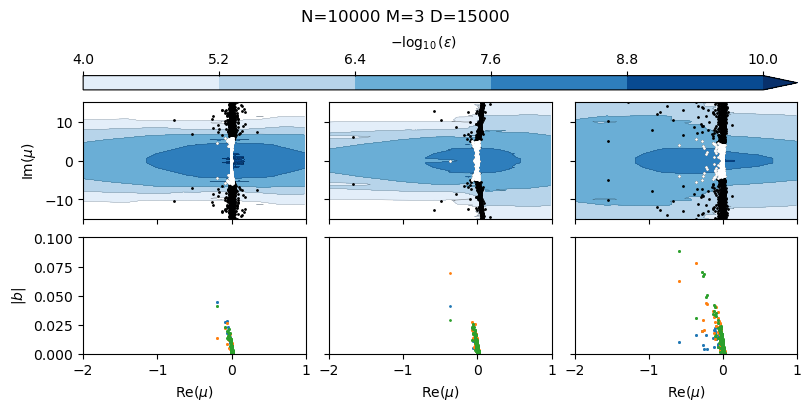

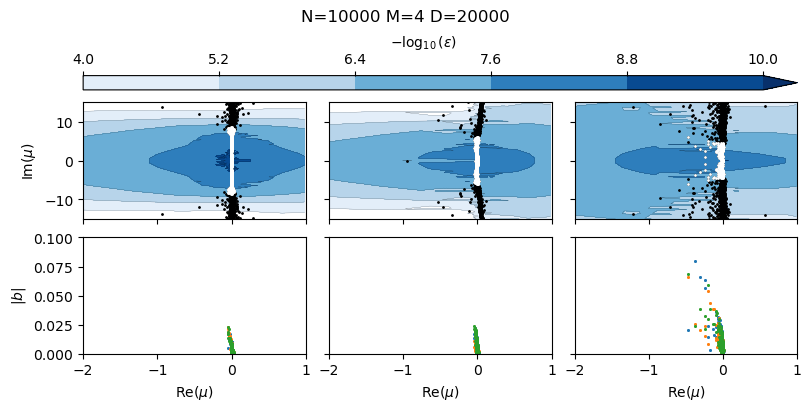

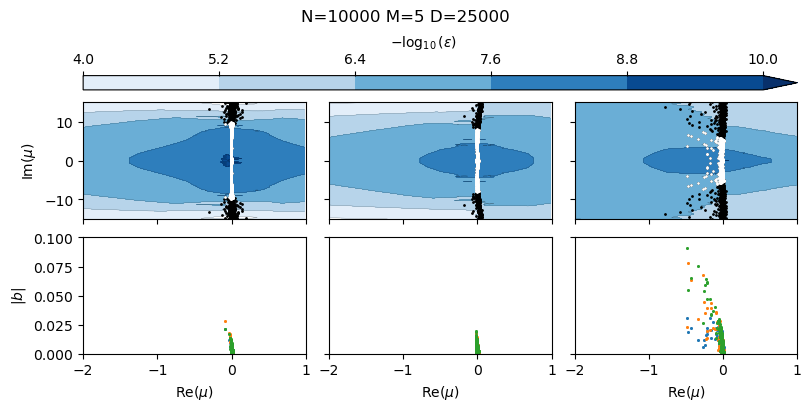

In [10]:
filebases=['data/dmd13/','data/dmd14/','data/dmd15/']
omega=np.fromfile(filebases[0]+'0'+'frequencies.dat',dtype=np.float64)
N=len(omega)

resmin=1E-4
resmax=1E-10
rescrit=1E-7

for D in ['0_r','1_r','2_r','3_r','4_r','5_r']:
    l=0
    fig,axs=plt.subplots(2,3,figsize=(8,4),layout='constrained')
    if D==0:
        fig.suptitle('N=%i M=%i D=%i'%(N,1,0))
    else:
        fig.suptitle('N=%i M=%i D=%i'%(N,int(D[0]),N//2*int(D[0])))
    numtraj=3
    for m in range(len(filebases)):
        try:
            filebase0=filebases[m]

            bs=np.load(filebase0+str(D)+'bs.npy')
            evals=np.load(filebase0+str(D)+'evals.npy')
            res=np.load(filebase0+str(D)+'res.npy')
            inds=np.where(res<rescrit)[0]
            xs=np.real(np.log(evals)/dt)
            n0s=np.concatenate([[0],np.cumsum(np.load('%s/%sn0s.npy'%(filebase0,D))-1)])

            plt.subplot(2,3,4+l)

            # plt.scatter(xs,np.abs(bs[0]),c='grey',s=2)
            for n in range(numtraj):
                plt.scatter(xs[inds],np.abs(bs[n0s[n]])[inds],c=colors[n],s=1,zorder=-5)
            plt.gca().set_rasterization_zorder(0)

            plt.xlabel(r'$\mathrm{Re}(\mu)$')
            plt.xlim(-2,1)
            plt.ylim(0,0.5)
            if l>0:
                plt.gca().set_yticks(plt.gca().get_yticks(),['']*len(plt.gca().get_yticks()))
            else:
                plt.ylabel(r'$|b|$')
            plt.ylim(0,0.1)

            pseudo1=np.load('%s/%spseudo.npy'%(filebase0,D))
            zs1=np.load('%s/%szs.npy'%(filebase0,D))
            evals1=np.load('%s/%sevals.npy'%(filebase0,D))
            res1=np.load('%s/%sres.npy'%(filebase0,D))
            nr=26
            ni=26

            levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5

            plt.subplot(2,3,1+l)
    #         cs1 = plt.gca().tricontour(np.real(np.log(zs1)/dt),np.imag(np.log(zs1)/dt),np.log(1/np.array(pseudo1))/np.log(10),levels=levels,colors='k',lw=1,extend='max',zorder=-5)
    #         cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1,zorder=-5)
            X=np.concatenate([np.real(np.log(zs1)/dt),np.real(np.log(evals1)/dt)])
            Y=np.concatenate([np.imag(np.log(zs1)/dt),np.imag(np.log(evals1)/dt)])
            C=np.concatenate([np.log(1/np.array(pseudo1))/np.log(10),np.log(1/np.array(res1))/np.log(10)])

            x=-3+4*np.arange(256)/256
            y=-15+30*np.arange(256)/256
            X2,Y2=np.meshgrid(x,y)
            xi=np.array([X2,Y2]).transpose(1,2,0).reshape(-1,2)
            C2=griddata(np.array([X,Y]).T,C,xi)
#             cs2=plt.gca().tripcolor(X2.ravel(),Y2.ravel(),C2,cmap='Blues',zorder=-6,vmin=-np.log(resmin)/np.log(10),vmax=-np.log(resmax)/np.log(10))
            cs2=plt.gca().tricontourf(X2.ravel(),Y2.ravel(),C2,cmap='Blues',zorder=-6,levels=levels,extend='max')
            inds=np.where(np.isfinite(C2))[0]
            cs1 = plt.gca().tricontour(X2.ravel()[inds],Y2.ravel()[inds],C2[inds],levels=levels,colors='k',linewidths=0.1,extend='max',zorder=-5)

            plt.gca().set_rasterization_zorder(0)
            plt.xlim(-2,1)
            plt.ylim(-15,15)

            xs1=np.real(np.log(evals1)/dt)
            ys1=np.imag(np.log(evals1)/dt)

            inds=np.where(res1<rescrit)[0]
            plt.scatter(xs1,ys1,c='black',s=1,zorder=-5)
            plt.scatter(xs1[inds],ys1[inds],c='white',s=1,zorder=-5)

            if l>0:
                plt.gca().set_yticklabels([])
            else:
                plt.ylabel('$\mathrm{Im}({\mu})$')
            plt.gca().set_xticklabels('')
        except:
            l=l+1
            continue
        l=l+1
    
    fig.colorbar(cs2, ax=axs[:,:], location='top',aspect=50,label=r'$-\log_{10}(\varepsilon)$')
    
    plt.savefig('oscillatordmd2_%s.pdf'%D,dpi=200)
    plt.show()
    